# The StanfordExtra dataset

This notebook visualises the capability of the StanfordExtra dataset, which contains 12,000 images of keypoint and segmentations for dogs.

## Accesing the images
For this demo notebook, a subset of 25 images stored in this repo will be used. The full dataset (the 20,580 images from which this dataset is derived) can be accessed here: [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/)

## Understanding the dataset
### Keypoints & Metadata

All of the relevant data is stored in a single .json file.
 This stores a list of entries, for which each entry is a dictionary of the following information:

- `img_path` - The image path within the Stanford Dogs Dataset download.
- `img_width` and `img_height`.
- `img_bbox` - Bounding box of dog, in form [x0, y0, width, height]
- `joints` - A (24 x 3) array stored as a list of lists. Corresponds to the 24 joints (see `keypoint_definitions.csv` ref for info on what these joints are). Each joint has its pixel (x, y) position stored, as well as a visibility flag.
- `seg` - Segmentation mask, stored in [pycoco's RLE](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/mask.py) format
- `is_multiple_dogs` - Flag to indicate if there are multiple dogs in the image

For this dataset, `x` and `y` are measured from the top left corner of the image.

## Using the dataset

The script below demonstrates the extraction of key information of the dataset, including keypoints, bounding boxes, and segmentations. It will visualise a sample of 25 dogs included in this repo.

First, load the .json

In [5]:
%matplotlib inline
import json, os
from csv import DictReader
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm
from PIL import Image, ImageFilter
from pycocotools.mask import decode as decode_RLE

# define file locations
img_dir = "sample_imgs"
def_file = "keypoint_definitions.csv"

# load json into memory
json_loc = "StanfordExtra_v1.json"
with open(json_loc) as infile:
	json_data = json.load(infile)

# convert json data to a dictionary of img_path : all_data, for easy lookup
json_dict = {i['img_path']: i for i in json_data}

# load keypoint labels and colours
with open(def_file) as infile:
	reader = DictReader(infile)
	colours = ["#"+row['Hex colour'] for row in reader]
	labels = [row['Name'] for row in reader]

First, we have to define the functions necessary for loading RLE formats. This can be done using the pycocotools Python API.

In [6]:
def get_seg_from_entry(entry):
	"""Given a .json entry, returns the binary mask as a numpy array"""

	rle = {
		"size": [entry['img_height'], entry['img_width']],
		"counts": entry['seg']
	}

	decoded = decode_RLE(rle)
	return decoded

Next, a function `get_dog` will be defined, which takes the name of a dog, and loads in all the relevant information as a dictionary

In [7]:
def get_dog(name):
	data = json_dict[name]

	# load img
	img_data = plt.imread(os.path.join(img_dir, data['img_path']))

	# load seg
	seg_data = get_seg_from_entry(data)

	# add to output
	data['img_data'] = img_data
	data['seg_data'] = seg_data

	return data

Now, we can take a sample from our dataset of 25 dogs, and plot all of the data provided by the dataset below:

e:\iib project data\stanfordextra\venv\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("binary_r"))


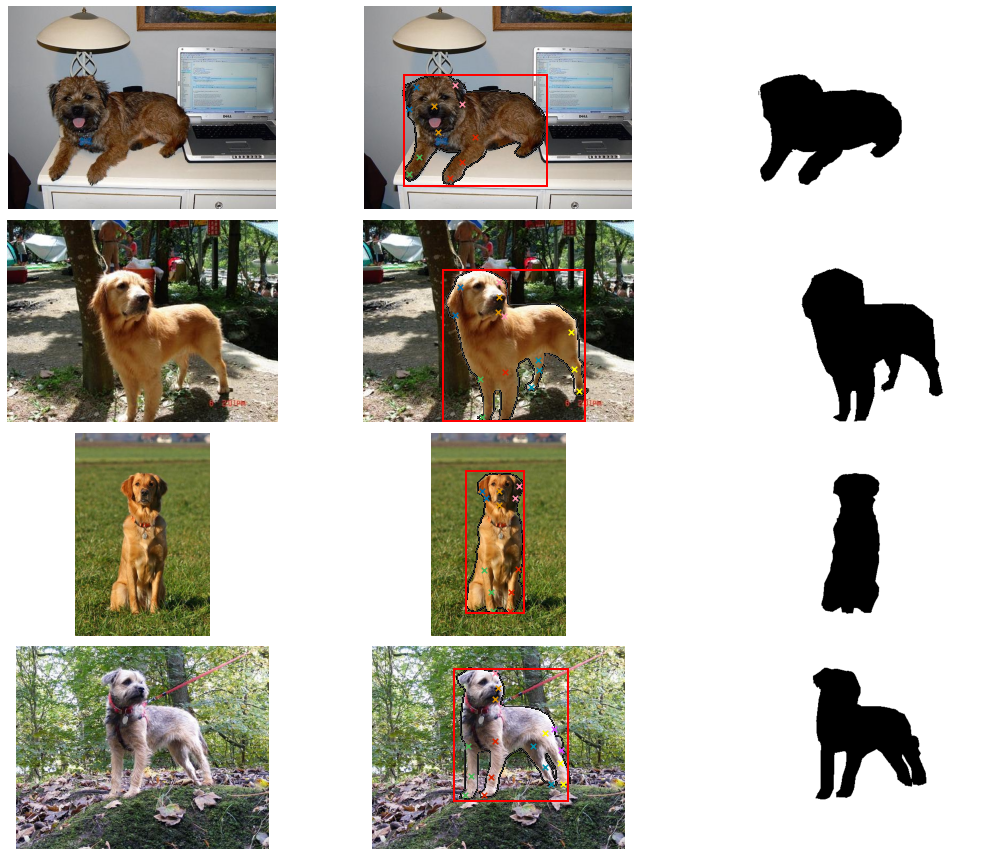

In [8]:
# get list of all available sample files
samples = []
for folder in os.listdir(img_dir):
	for file in os.listdir(os.path.join(img_dir, folder)):
		samples.append(f"{folder}/{file}")

# select 4 samples
n_samples = 4
selected_samples = np.random.choice(samples, n_samples, replace=False)

# Plot three figures:
# image | image with bbox, outline, and keypoints | seg
fig, axes = plt.subplots(nrows = n_samples, ncols=3, figsize=(16,12))
[ax.axis("off") for ax in np.ravel(axes)] # turn off all axes

# colourmap for seg outline
cmap = cm.binary_r
cmap.set_under('k', alpha=0)

for (ax_orig, ax_all, ax_seg), sample in zip(axes, selected_samples):
	data = get_dog(sample)
	ax_orig.imshow(data['img_data'])
	ax_all.imshow(data['img_data'])

	# add outline of segmentation
	seg_outline = Image.fromarray(data['seg_data'])
	seg_outline = np.asarray(seg_outline.filter(ImageFilter.FIND_EDGES)).copy()
	ax_all.imshow(seg_outline, cmap=cmap, clim=0.1)
				  #alpha = 0.8)

	# plot keypoints
	for idx, (x, y, v) in enumerate(data['joints']):
		if v == 0:
			continue # ignore any invisible keypoints
		ax_all.scatter([x], [y], c=[colours[idx]], marker="x", s=30)

	# plot bbox
	x0, y0, width, height = data['img_bbox']
	bbox = Rectangle((x0, y0), width, height, linewidth=2, edgecolor="red", fill=None)
	ax_all.add_patch(bbox)

	# plot pure seg
	ax_seg.imshow(data['seg_data'], cmap="binary")

plt.tight_layout()
plt.show()

Notes:
- The above code discards any non-visible keypoints. However, some invisible keypoints may be useful
- Any point that was not labelled is stored as `[0., 0., 0.]`
